In [26]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import scikeras
from scikeras.wrappers import KerasRegressor
from keras.callbacks import History
import os
import pandas as pd
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [28]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='layers_flatten'),
    tf.keras.layers.Dense(512, activation='relu', name='layers_dense'),
    tf.keras.layers.Dropout(0.2, name='layers_dropout'),
    tf.keras.layers.Dense(10, activation='softmax', name='layers_dense_2')
  ])

In [29]:
os.curdir

'.'

In [30]:
model = create_model()

In [31]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir(): 
    import time 
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") 
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_logdir, histogram_freq=1)

In [32]:
run_logdir

'.\\my_logs\\run_2023_07_29-18_37_12'

In [33]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [34]:
%%capture

history = model.fit(x=x_train,
                    y=y_train,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[tensorboard_callback])

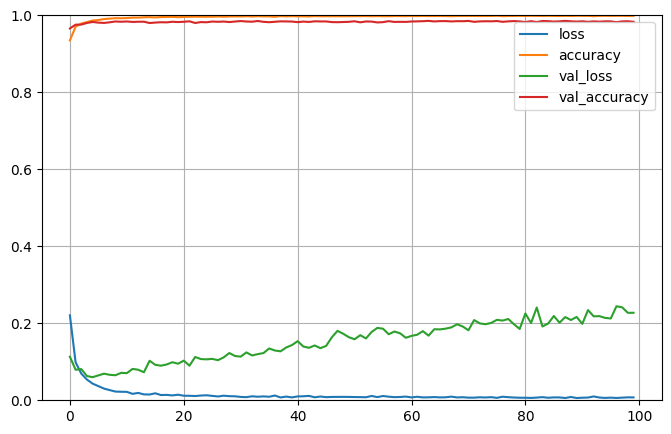

In [35]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [36]:
%tensorboard --logdir=.\\my_logs

Reusing TensorBoard on port 6006 (pid 20252), started 6 days, 4:48:16 ago. (Use '!kill 20252' to kill it.)

In [37]:
housing = fetch_california_housing()

In [38]:
X_train_full, X_test, y_train_full, y_test = train_test_split( housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full)

In [39]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_valid_scaled = scaler.transform(X_valid) 
X_test_scaled = scaler.transform(X_test)

In [40]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model
    

In [41]:
#%pip install scikeras[tensorflow]

In [42]:
keras_reg =  KerasRegressor(build_model)

In [43]:
history = keras_reg.fit(X_train_scaled, y_train, epochs=100,
                        verbose=0,
                        validation_data=(X_valid_scaled, y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test_scaled, y_test)
y_pred = keras_reg.predict(X_test[:3])

1/1 [==============================] - 0s 19ms/step


In [44]:
def build_model(n_hidden, n_neurons, meta):
    model = keras.models.Sequential()
    # note that I added the meta parameter, you can access all of the SciKeras attributes
    # https://scikeras.readthedocs.io/en/latest/generated/scikeras.wrappers.KerasRegressor.html
    n_features_in_ = meta["n_features_in_"]
    model.add(keras.layers.InputLayer(input_shape=(n_features_in_, )))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    return model  # note that I return an un-compiled model here, SciKeras will compile it for you!


keras_reg = scikeras.wrappers.KerasRegressor(
    build_model,
    n_neurons=30,
    n_hidden=1,
    optimizer__lr=3e-3,  # just specify parameters here, you won't have to edit build_model to add/remove things you're tuning
    optimizer=keras.optimizers.SGD,  # note that I am giving SciKeras a class, not an instance
   loss="mse",
)
    

param_distribs = {
    "n_hidden" : [0, 1, 2, 3],
    "n_neurons" : np.arange(1, 100, 10),
    "optimizer__lr" : np.arange(3e-4, 3e-2, 0.3*(1e-2 - 1e-4))
}

In [45]:
np.arange(1, 100)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

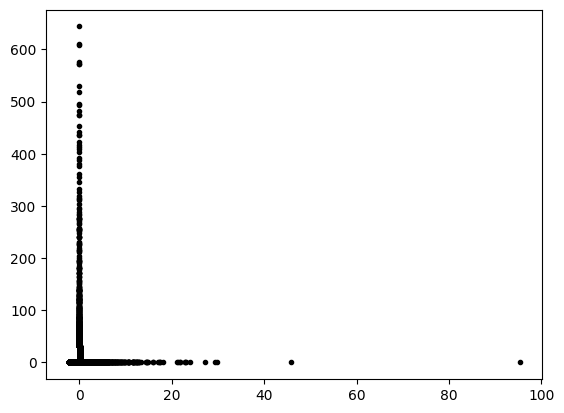

In [46]:
fig, ax = plt.subplots(1, 1)

rv = reciprocal(3e-4, 3e-2)
ax.plot(X_train_scaled, rv.pdf(X_train_scaled), 'k.', lw=2, label='frozen pdf')

In [47]:
%%capture
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [48]:
rnd_search_cv.best_params_

{'optimizer__lr': 0.02406, 'n_neurons': 81, 'n_hidden': 3}

In [49]:
rnd_search_cv.best_score_

0.7761536780058028

In [50]:
model = rnd_search_cv.best_estimator_.model